<img src = "https://raw.githubusercontent.com/touchaee/touchaee.github.io/master/images/Project-Capstone.png">
<h1 align = center>Where to open a new Thai restaurant in New York?</h1>

## Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Over the last 20 years, Thai restaurants have been one of the fastest-growing dining categories in New York City. Ever since the advent of places specializing in regional cuisines, often presenting recipes not seen here before, the Thai dining scene has been more exciting than ever before. So that now we have the fiery food of Isan in the northeast, the mellower food of Chiang Mai near the Burmese border, oodles of noodles from Sukhothai, the curries of central and southern Thailand, the urban cuisine of Bangkok, and the Malaysian-leaning food of the peninsula. Our newest arrival is the food of the capital’s Chinatown.

But the pandemic has been tough on Thai restaurants, a one-third have closed, mostly as a result of the pandemic. The good news is that new places have arisen to replace them; in fact, Thai has been most prominent in the category of new restaurants, as will be shown in what follows, along with lots of highly recommended old favorites.

This project aims to find a location for the opening of a Thai restaurant in NY, Specifically, this report will be targeted to stakeholders interested in opening any restaurant place like **Thai Restaurant** in **New York City**.

The first task would be to **find the areas lack Thai Restaurants** by analyzing restaurant data from FourSquare API and **shortlisting an area**, where Thai restaurant is not amongst the most common venues.

We will make use of our data science tools to analyze data and focus on the areas and explore its areas and the 10 most common venues in each area so that the best areas where Thai restaurant is not amongst the most common venue can be selected.

## Data <a name="data"></a>

Based on the definition of our problem, the factors that will influence our decision are:
* finding the areas lack Thai Restaurants
* finding the most common venues
* Choosing the right neighborhood within the borough

We will be using the geographical coordinates of NY to plot neighborhoods in a borough that is lack of Thai Restaurant and in the city's vicinity, and finally, cluster our neighborhoods and present our findings.

Following data sources will be needed to extract/generate the required information:

- [**Part 1**: Using a real-world data set from Kaggle containing the Vancouver Crimes from 2003 to 2019](#part1):  A dataset consisting of the crime statistics of each Neighborhood in Vancouver along with the type of crime, recorded year, month, and hour.

- [**Part 2**: Gathering additional information on the list of officially categorized boroughs in Vancouver from Wikipedia.](#part2): Borough information will be used to map the existing data where each neighborhood can be assigned with the right borough.

- [**Part 3**: Creating a new consolidated dataset of the Neighborhoods, along with their boroughs, crime data, and the respective Neighbourhood's co-ordinates.](#part3): This data will be fetched using OpenCage Geocoder to find the safest borough and explore the neighborhood by plotting it on maps using Folium and perform exploratory data analysis.

- [**Part 4**: Creating a new consolidated dataset of the Neighborhoods, boroughs, and the most common venues and the respective Neighbourhood along with co-ordinates.](#part4): This data will be fetched using Four Square API to explore the neighborhood venues and to apply a machine learning algorithm to cluster the neighborhoods and present the findings by plotting it on maps using Folium.

### Importing all the necessary Libraries

In [35]:
import numpy as np
import pandas as pd

# use the inline backend to generate the plots within the browser
%matplotlib inline 

#Importing Matplot lib and associated packages to perform Data Visualisation and Exploratory Data Analysis
import matplotlib as mpl
import matplotlib.pyplot as plt

#mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

#Importing itertools for visualize
from itertools import cycle, islice

print('Libraries imported')

Matplotlib version:  3.1.0
Libraries imported


### **Part 1:** Using a IBM dataset containing the New York Borough, Neighborhood and geometry coordinates<a name="part1"></a>


####  New York Dataset

Properties of the New York dataset

*   Borough - Recorded borough
*   Neighborhood - Recorded neighborhood
*   Latitude - Recorded latitude
*   Longitude - Recorded longitude


Data set URL: https://cocl.us/new_york_dataset

In [2]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        # get Borough and Neighborhood
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        # get Latitude and Longitude
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [3]:
df = get_new_york_data()

In [77]:
df.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Total Neighborhood in different Borough

In [48]:
df_count_neigh = df.groupby('Borough').count()['Neighborhood'].sort_values(ascending = False).to_frame()

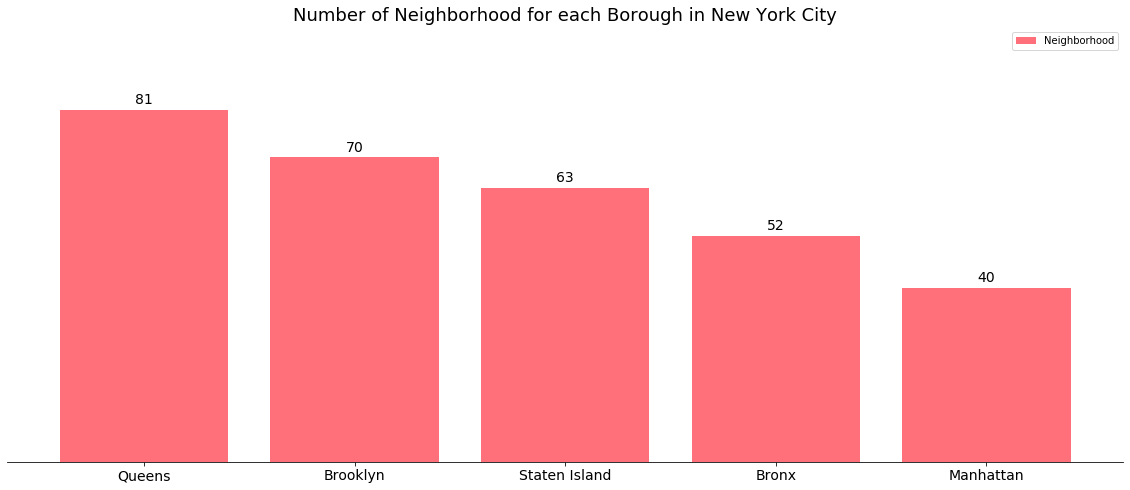

In [75]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Number of Neighborhood for each Borough in New York City"

#Create ax
ax = df_count_neigh.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 0)
ax.set_ylim(0, 100)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_neigh.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

'''
#percentage on Movie
plt.annotate('',              # s: str. Will leave it blank for no text
     xy=(0.7, 90),          # place head of the arrow at point (year 2012 , pop 70)
     xytext=(0, 60),      # place base of the arrow at point (year 2008 , pop 20)
     xycoords='data',         # will use the coordinate system of the object being annotated 
     arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='#3790E8', lw=4)
    )

plt.annotate(
    'Queens',
    xy = (0.7, 90),
    fontsize= 16
)
'''

plt.show()

We see that Queens has highest numbe\r of neighborhoods

### **Part 2:** Gathering Thai Restaurant data for each neighborhood from FoursquareAPI<a name="part2"></a>

#### Define a function to intract with FourSquare API
get top 200 venues within a radius of 1500 metres for a given latitude and longitude. Below function will return us the venue id , venue name, category, latitude and longitude.

In [97]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=200
    CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' # changed my Foursquare ID
    CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_lat = row['venue']['location']['lat']
            venue_lng = row['venue']['location']['lng']
            venue_details.append([venue_id,venue_name,venue_category,venue_lat,venue_lng])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category','Venue_lat','Venue_lng']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

#### Define a function to get venue details.

In [98]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'RZDYH51XGA4ZLDY3HLI5UWLNWEKUMMLKGYABRT2CGO12XCBZ' # changed my Foursquare ID
    CLIENT_SECRET = '4ZPM33XMBRGDBG4KWJZJ2VS5CXDGYGAVGWJ2QS3QSRDPGLWE' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_price_message = venue_data['price']['message']
        venue_price_tier = venue_data['price']['tier']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips,venue_price_message,venue_price_tier])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips','Price_message','Price_tier']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

### Collect Thai restaurant data for each neighborhood and borough

In [104]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name', 'Category','Venue_lat','Venue_lng']
Thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in df.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Thai_resturants = venues[venues['Category'] == 'Thai Restaurant']   
    #print('(', count, '/', len(df), ')', 'Thai Resturants in '+ Neighborhood + ', ' + Borough + ':' + str(len(indian_resturants)))
    print(f'({count}/{len(df)}) Thai Resturants in {Neighborhood}, {Borough} : {str(len(Thai_resturants))}')
    for resturant_detail in Thai_resturants.values.tolist():
        id, name , category, venue_lat, venue_lng = resturant_detail
        Thai_rest_ny = Thai_rest_ny.append({'Borough': Borough,
                                            'Neighborhood': Neighborhood, 
                                            'ID': id,
                                            'Name' : name,
                                            'Category' : category,
                                            'Venue_lat' : venue_lat,
                                            'Venue_lng' : venue_lng
                                               }, ignore_index=True)
    count+=1

done
(1/306) Thai Resturants in Wakefield, Bronx : 0
done
(2/306) Thai Resturants in Co-op City, Bronx : 0
done
(3/306) Thai Resturants in Eastchester, Bronx : 0
done
(4/306) Thai Resturants in Fieldston, Bronx : 0
done
(5/306) Thai Resturants in Riverdale, Bronx : 1
done
(6/306) Thai Resturants in Kingsbridge, Bronx : 1
done
(7/306) Thai Resturants in Marble Hill, Manhattan : 1
done
(8/306) Thai Resturants in Woodlawn, Bronx : 0
done
(9/306) Thai Resturants in Norwood, Bronx : 0
done
(10/306) Thai Resturants in Williamsbridge, Bronx : 0
done
(11/306) Thai Resturants in Baychester, Bronx : 0
done
(12/306) Thai Resturants in Pelham Parkway, Bronx : 0
done
(13/306) Thai Resturants in City Island, Bronx : 0
done
(14/306) Thai Resturants in Bedford Park, Bronx : 0
done
(15/306) Thai Resturants in University Heights, Bronx : 0
done
(16/306) Thai Resturants in Morris Heights, Bronx : 0
done
(17/306) Thai Resturants in Fordham, Bronx : 0
done
(18/306) Thai Resturants in East Tremont, Bronx : 

Save dataframe as csv named _'thai_rest_ny.csv'_

In [117]:
Thai_rest_ny.to_csv('thai_rest_ny.csv')

In [127]:
Thai_rest_ny = pd.read_csv('thai_rest_ny.csv', index_col = 0)

In [128]:
Thai_rest_ny.head()

,Borough,Neighborhood,ID,Name,Category,Venue_lat,Venue_lng
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,Thai Restaurant,40.878796,-73.916701
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Thai Restaurant,40.847845,-73.831320
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,Thai Restaurant,40.838048,-73.863917


In [129]:
print(Thai_rest_ny.shape)

(140, 7)


### Further Cleaning the data by dropping rows with duplicated data

In [130]:
Thai_rest_ny.drop_duplicates(subset = ['ID'], inplace = True)
Thai_rest_ny.reset_index(inplace = True, drop = True)

In [131]:
Thai_rest_ny.head()

,Borough,Neighborhood,ID,Name,Category,Venue_lat,Venue_lng
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,Thai Restaurant,40.886388,-73.910025
1,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,Thai Restaurant,40.878796,-73.916701
2,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,Thai Restaurant,40.847845,-73.831320
3,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,Thai Restaurant,40.838048,-73.863917
4,Bronx,Pelham Bay,57097b8b498e5431176ca914,Tana Thai Restaurant,Thai Restaurant,40.851395,-73.843658


In [132]:
print(Thai_rest_ny.shape)

(100, 7)


We got 100 Indian Resturants across New York City

In [143]:
df_count_res_borough = Thai_rest_ny.groupby('Borough').count()['ID'].sort_values(ascending = False).to_frame()

In [151]:
df_count_res_neighborhood = Thai_rest_ny.groupby('Neighborhood').count()['ID'].sort_values(ascending = False)[0:5].to_frame()

<Figure size 432x288 with 0 Axes>

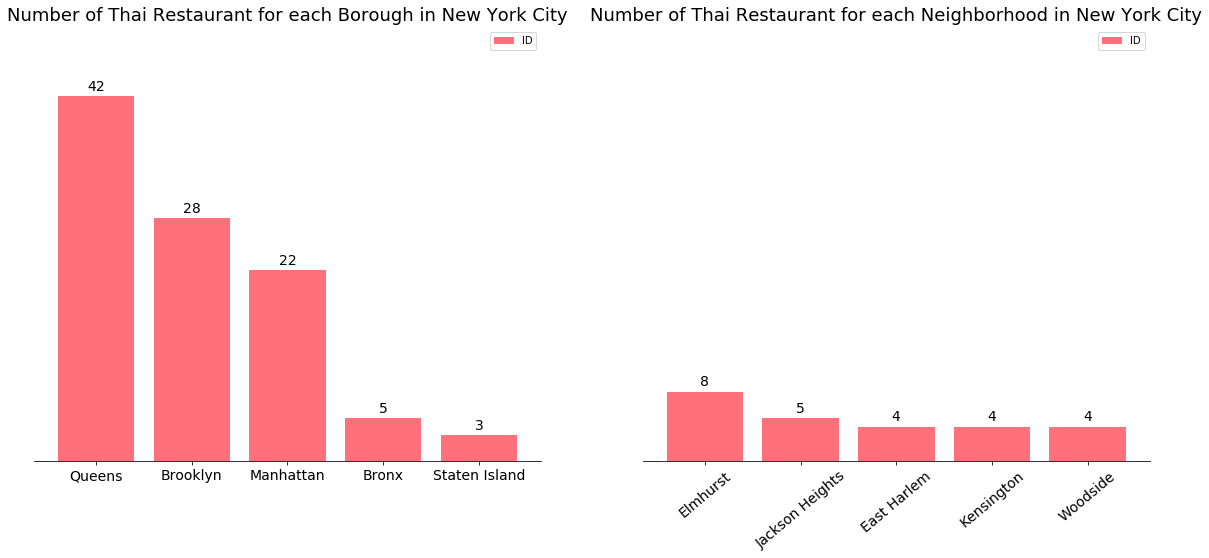

In [163]:
#set ax parameters
figsize = (20, 8)
width = 0.8
title = "Number of Thai Restaurant for each Borough in New York City"

plt.clf()
fig, axes = plt.subplots(nrows=1, ncols=2)

#Plot Borough
#Create ax
ax = df_count_res_borough.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 0, ax = axes[0])
ax.set_ylim(0, 50)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_res_borough.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

#Plot Neighborhood   
title = "Number of Thai Restaurant for each Neighborhood in New York City"    
#Create ax
ax = df_count_res_neighborhood.plot(kind = 'bar', figsize = figsize, width = width, color = '#FF707B', rot = 40, ax = axes[1])
ax.set_ylim(0, 50)

#Text Decoration
ax.set_title(title, fontdict = {'fontsize': 18})
ax.set_xticklabels(df_count_res_neighborhood.index, fontdict = {'fontsize': 14})
ax.set_xlabel("")

#Borderless
ax.set_yticklabels("")
ax.get_yaxis().set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for p in ax.patches:                 
    ax.annotate(
        "{}".format(p.get_height()),
        (p.get_x()+p.get_width()/2., p.get_height()), 
        ha='center',
        va='center', 
        xytext=(0, 10),
        textcoords='offset points', 
        fontsize = 14
    )

plt.show()

we see that **Queens** has the most number of Thai restaurants and **Elmgurst Neighborhood** also has the most Thai restaurants.

### **Part 3:** Gathering additional information about the Thai Restaurant for each neighborhood from FoursquareAPI<a name="part3"></a>

In [165]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips', 'Price_message', 'Price_tier']
Thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in Thai_rest_ny.values.tolist():
    Borough, Neighborhood, ID, Name, Category, Venue_lat, Venue_lng = row
    try:
        venue_details = get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips, price_message, price_tier = venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    #print('(',count,'/',len(indian_rest_ny),')','processed')
    print(f'({count}/{len(Thai_rest_ny)}), done')
    Thai_rest_stats_ny = Thai_rest_stats_ny.append({'Borough': Borough,
                                                    'Neighborhood': Neighborhood, 
                                                    'ID': id,
                                                    'Name' : name,
                                                    'Likes' : likes,
                                                    'Rating' : rating,
                                                    'Tips' : tips,
                                                    'Price_message': price_message,
                                                    'Price_tier': price_tier
                                                   }, ignore_index=True)
    count+=1

                         ID      Name  Likes  Rating  Tips Price_message  \
0  4b94a4a2f964a520787f34e3  Nam Thai      3     7.1     5      Moderate   

   Price_tier  
0           2  
(1/100), done
                         ID         Name  Likes  Rating  Tips Price_message  \
0  4a739e29f964a520f5dc1fe3  Siam Square     15     7.4    13      Moderate   

   Price_tier  
0           2  
(2/100), done
                         ID                   Name  Likes  Rating  Tips  \
0  4b4c90d3f964a52046b626e3  Honey's Thai Pavilion     19     7.3    27   

  Price_message  Price_tier  
0         Cheap           1  
(3/100), done
                         ID          Name  Likes  Rating  Tips Price_message  \
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.2     1      Moderate   

   Price_tier  
0           2  
(4/100), done
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips, Price_message, Price_tier]
Index: []
No data available for id= 57097b8b498e5431176ca914
(5/100), done
Empty

In [166]:
Thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Price_message,Price_tier
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5,Moderate,2
1,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,7.4,13,Moderate,2
2,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.3,27,Cheap,1
3,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.2,1,Moderate,2
4,Bronx,Pelham Bay,0,0,0,0.0,0,Moderate,2
